<a href="https://colab.research.google.com/github/KaleabTessera/ICOOmen_ML_Model/blob/master/ICOData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ICOOmen
# A machine Learning Model to predict ICO prices

## Importing Required Libraries and Creating data loading function

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix
from random import randint
from datetime import datetime
from enum import Enum
import os

In [3]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.externals import joblib

In [4]:
class LineaReggressionMetrics(Enum):
    R_SQUARED = 1
    ROOT_MEAN_SQUARED_ERROR = 2

In [5]:
def load_dataset(dataset='./dataset/ico_data_final.csv'):
    all_data = np.genfromtxt(fname=dataset, names=True, delimiter=',')
    featureNames = all_data.dtype.names[1:-1]
    ico_names = np.genfromtxt(fname=dataset, delimiter=',', usecols=0, dtype=str,skip_header=1)
    all_data = np.genfromtxt(fname=dataset, delimiter=',',skip_header=1)[:,1:]
    x = np.genfromtxt(fname=dataset, delimiter=',',skip_header=1)[:,1:-1]
    y = np.genfromtxt(fname=dataset, delimiter=',',skip_header=1)[:,-1]
    return (featureNames,x,y)

Investigating covariance between inputs and output.

In [6]:
def getCovarianceMatrixAndPrintScatterPlot(x,y,saveToFile=False):
    nrows = x.shape[0]
    ncols = x.shape[1]

    for i in np.arange(ncols):
        corCoef = np.corrcoef(x[:,i], y) 
        plt.xlabel(featureNames[i])
        plt.ylabel("Price after 6 months(in $) ")
        plt.suptitle('Scatter Plot of feature {:s} vs Price after 6 months'.format(featureNames[i]))
        corr = "Correlation Coefficient: "+str(corCoef[0,1])
        plt.title(corr)
        plt.scatter(x[:,i], y)
        if(saveToFile == True):
            plt.savefig('images/{:s}_vs_Price_scatter_plot.png'.format(featureNames[i]))
        else: 
            plt.show()
        
        plt.clf() 

In [7]:
def createResultsFolderIfDoesntExist(folder):
    if not os.path.exists(folder):
      os.makedirs(folder)
      #download best models from github - mainly for google colab
      !wget https://github.com/KaleabTessera/ICOOmen_ML_Model/raw/master/results/bestRegressionModel_LineaReggressionMetrics.ROOT_MEAN_SQUARED_ERROR.sav -P "./results/"
      !wget https://github.com/KaleabTessera/ICOOmen_ML_Model/raw/master/results/bestRegressionModel_LineaReggressionMetrics.R_SQUARED.sav -P "./results/" 

In [8]:
createResultsFolderIfDoesntExist("results/")

In [9]:
# Mainly for google colab
def downloadDataifNotPresent(fileName='./dataset/ico_data_final.csv'):
  exists = os.path.isfile(fileName)
  if not exists:
      !wget https://github.com/KaleabTessera/ICOOmen_ML_Model/raw/master/dataset/ico_data_final.csv -P "./dataset/"

In [10]:
downloadDataifNotPresent()

## Loading ico dataset

In [23]:
featureNames,x,y = load_dataset()

## Print Scatter plots of inputs vs output

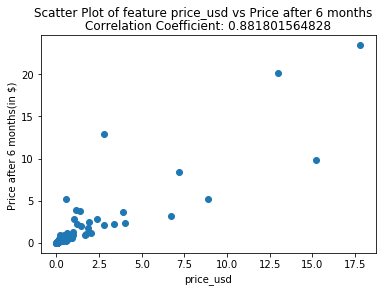

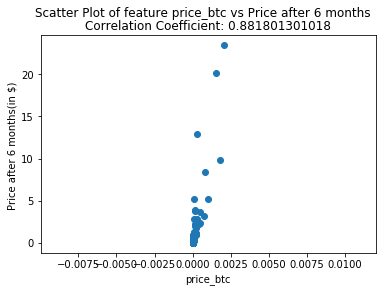

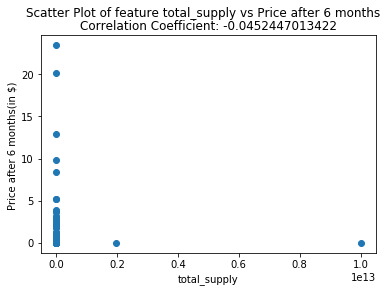

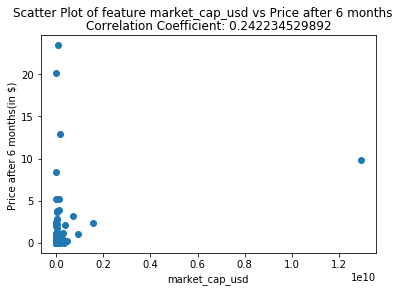

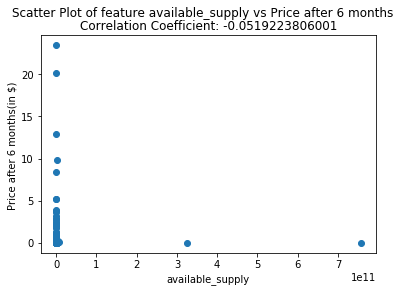

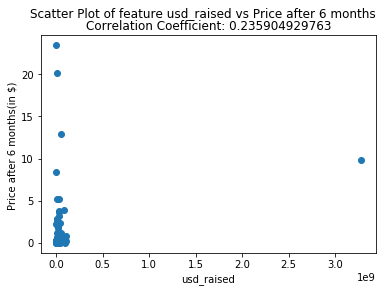

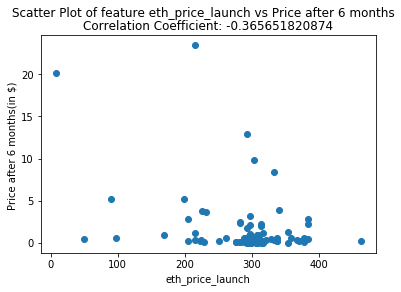

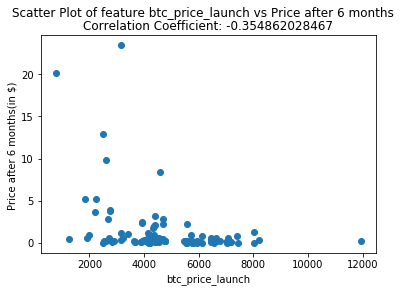

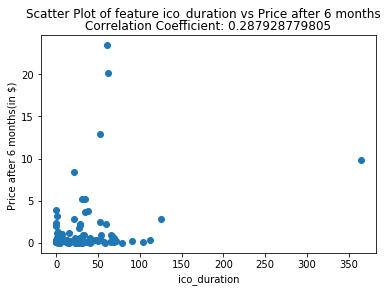

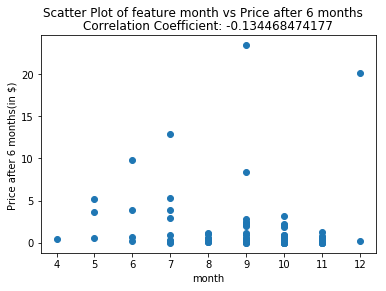

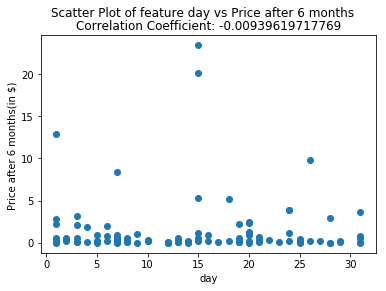

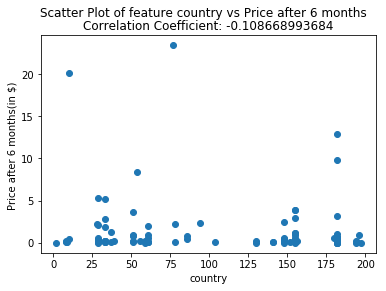

<Figure size 432x288 with 0 Axes>

In [12]:
getCovarianceMatrixAndPrintScatterPlot(x,y)

# One hot encoding of categorical fields


In [30]:
from sklearn.preprocessing import OneHotEncoder

def encodeData(x):
    enc = OneHotEncoder(categorical_features='all',
           handle_unknown='error', sparse=False)


    encodedCategoryArray= enc.fit_transform(x[:,8:12])
    allInputsExceptCategorical = np.delete(x, np.s_[8:12], axis=1)
    encodedX = np.concatenate((allInputsExceptCategorical,encodedCategoryArray),axis=1)
    return encodedX

def encodeSingleElement(x,sample):
    enc = OneHotEncoder(categorical_features='all',
           handle_unknown='error', sparse=False)


    encodedCategoryArray= enc.fit(x[:,8:12])
    allInputsExceptCategorical = np.delete(sample, np.s_[8:12], axis=0)
    
    encodedCategories  = enc.transform(sample[8:12].reshape(1, -1))
    encodedX = np.concatenate((allInputsExceptCategorical,encodedCategories.flatten()),axis=0)
    return encodedX

In [23]:
encodedX = encodeData(x)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:375: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. The passed value of 'all' is the default and can simply be removed.
  DeprecationWarning)


## Function to Plot Performace

In [13]:
def plotExpectedVsPredictedOutput(y_test,y_pred,fileName='',saveToFile=False):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(y_test, y_pred,alpha=0.8,edgecolors=(0, 0, 0),s=30)
    ax.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--', lw=2)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.title(fileName)
    if(saveToFile == True):
        plt.savefig('images/'+fileName+".png")
    else: 
        plt.show()


# Train/Test Split and Cross Validation
Following - 80/20 split cross validation and test data. Then later, the cross validation data will also be split 80/20 to follow the holdout method.

In [14]:
X_cross, X_test_holdout, y_cross, y_test_holdout = train_test_split(encodedX, y,test_size=0.2,train_size=0.8)


# Linear Regression - implementation

## Linear Regression with train/test split - 80/20 split on Training Data

In [15]:
def linearRegression(x,y):
    
    X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.2,train_size=0.8)

    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rMeanSquaredError = sqrt(mean_squared_error(y_test, y_pred))
    return regr,regr.coef_,rMeanSquaredError,r2,X_test,y_test,y_pred

## Function to optimize results

In [46]:
## Save model only if it is performs better than current saved model
def saveBestModel(model,fileName):
    bestSavedRegressionModel = joblib.load(fileName)
    
    #Scores for saved model
    y_pred_holdout_saved_model = bestSavedRegressionModel.predict(X_test_holdout)
    rSquared_saved_model = r2_score(y_test_holdout, y_pred_holdout_saved_model)
    rMse_saved_model = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout_saved_model))
    
    #Scores for new model
    y_pred_holdout_new_model = model.predict(X_test_holdout)
    rSquared_new_model = r2_score(y_test_holdout, y_pred_holdout_new_model)
    rMse_new_model = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout_new_model))
    
    # Check if we saving to file with best rMse or rSquared value    
    if(str(LineaReggressionMetrics.ROOT_MEAN_SQUARED_ERROR) in fileName):
        if(rMse_new_model < rMse_saved_model):
            joblib.dump(model, fileName) 
    else:
        if(rSquared_new_model < rSquared_saved_model):
            joblib.dump(model, fileName)
    

In [47]:
def linearRegressionRunnerOptimize(metricToOptimize,numIterations,x,y,showOutput = True,saveToFile=False):
    maxRSquared = -10000
    rMSEMin = 10000
    bestPredY = 0
    bestRegressionCoef = np.array([])
    for i in np.arange(numIterations):
        bestRegression,regressionCoef,rootMeanSquaredError,rSquared,X_test,y_test,y_pred = linearRegression(x,y)
#         if you are looking for best rMSE
        if(metricToOptimize == LineaReggressionMetrics.ROOT_MEAN_SQUARED_ERROR):
            if(rootMeanSquaredError < rMSEMin ):
                rMSEMin = rootMeanSquaredError
                bestPredY = y_pred
                bestRegressionCoef = regressionCoef
            if(showOutput):
                print(i,"bestrMSE:",rMSEMin)
#         if you are looking for best rSquared Value
        else:
            if(rSquared > maxRSquared ):
                maxRSquared = rSquared
                bestPredY = y_pred
                bestRegressionCoef = regressionCoef
            if(showOutput):
                print(i,"bestRSquared:",maxRSquared)
    
    fileName = ''
    crossValidationR2Squared = r2_score(y_test, y_pred)
    crossValidationMeanSquaredError = sqrt(mean_squared_error(y_test, y_pred))
    
    if(metricToOptimize == LineaReggressionMetrics.ROOT_MEAN_SQUARED_ERROR):
        print(" \n Best rMSE: {:f} \n ,after running linear regression {:d} different times with different test and training combinations"
              .format(rMSEMin,numIterations))
        print(" \n Best rMSE using holdout data: {:f} \n ,after running linear regression {:d} different times with different test and training combinations"
              .format(crossValidationMeanSquaredError,numIterations))
    else: 
        print(" \n Best RSquared: {:f} \n ,after running linear regression {:d} different times with different test and training combinations"
              .format(maxRSquared,numIterations))
        print(" \n Best RSquared using holdout data: {:f} \n ,after running linear regression {:d} different times with different test and training combinations"
              .format(crossValidationR2Squared,numIterations))
    
    if(showOutput):
        print(" \n Best regression coef:",bestRegressionCoef,"\n")
    
    #Save Best Model
    fileName = "results/" + "bestRegressionModel_" + str(metricToOptimize) + ".sav"
    saveBestModel(bestRegression, fileName)

## Best root mean squared error 
After running linear regression with n different combinations of training and test data

In [54]:
n = 10000 #Decreased to run faster if tested.
showOutput = False
saveToFile = False
linearRegressionRunnerOptimize(LineaReggressionMetrics.ROOT_MEAN_SQUARED_ERROR,n,X_cross,y_cross,showOutput,saveToFile)


 
 Best rMSE: 1.012423 
 ,after running linear regression 10000 different times with different test and training combinations
 
 Best rMSE using holdout data: 1.913630 
 ,after running linear regression 10000 different times with different test and training combinations


## Best RSquared Score over n interations
After running linear regression with n different combinations of training and test data

In [55]:
n = 10000 #Decreased to run faster if tested.
showOutput = False
saveToFile = False
linearRegressionRunnerOptimize(LineaReggressionMetrics.R_SQUARED,n,X_cross,y_cross,showOutput,saveToFile)

 
 Best RSquared: 0.926332 
 ,after running linear regression 10000 different times with different test and training combinations
 
 Best RSquared using holdout data: -0.539529 
 ,after running linear regression 10000 different times with different test and training combinations


## Load Saved Linear Regression Models and Print out performance

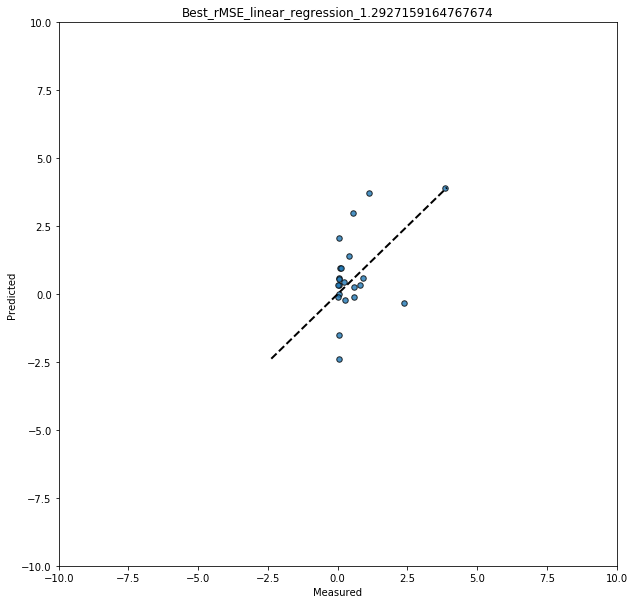

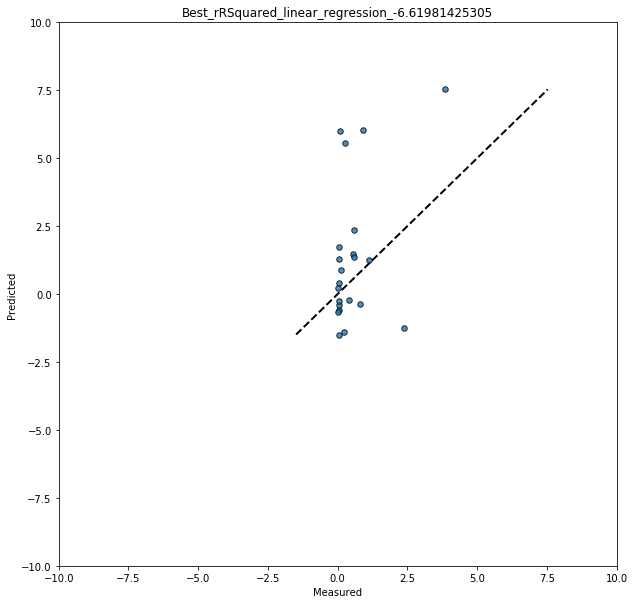

In [56]:
## Load model with best root mean squared error score 
fileName = "results/" + "bestRegressionModel_" + str(LineaReggressionMetrics.ROOT_MEAN_SQUARED_ERROR) + ".sav"
bestRegression = joblib.load(fileName)

y_pred_holdout = bestRegression.predict(X_test_holdout)
holdOutMeanSquaredError = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout))
heading = "Best_rMSE_linear_regression_" + str(holdOutMeanSquaredError)
plotExpectedVsPredictedOutput(y_test_holdout,y_pred_holdout,heading,saveToFile)

## Load model with best rSquared Score
fileName = "results/" + "bestRegressionModel_" + str(LineaReggressionMetrics.R_SQUARED) + ".sav"
bestRegression = joblib.load(fileName)

y_pred_holdout = bestRegression.predict(X_test_holdout)
holdOutValidationR2Squared = r2_score(y_test_holdout, y_pred_holdout)
heading = "Best_rRSquared_linear_regression_" + str(holdOutValidationR2Squared)
plotExpectedVsPredictedOutput(y_test_holdout,y_pred_holdout,heading,saveToFile)

# Use Model to make prediction - Value of ICO after 6 months

In [32]:
# Load model with best rMse and make prediction
fileName = "results/" + "bestRegressionModel_" + str(LineaReggressionMetrics.ROOT_MEAN_SQUARED_ERROR) + ".sav"
bestRegression = joblib.load(fileName)

#Example ICO
example_x = np.array([1.71456,0.00019931,1000000000,905793616,528295082,24000000,297.63,3420.4,7,8,9,182])

encoded_x = encodeSingleElement(x,example_x)
y_pred = bestRegression.predict(encoded_x.reshape(1, -1))

print("Predicted value of example ICO after 6 months: ",y_pred )

Predicted value of example ICo after 6 months:  [ 1.0826993]


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:375: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. The passed value of 'all' is the default and can simply be removed.
  DeprecationWarning)


# Neural Network - implementation

In [0]:
class Activations(Enum):
    identity = 1
    logistic = 2
    tanh    = 3
    relu = 4

class Solvers(Enum):
    lbfgs = 1
    sgd = 2
    adam = 3

In [0]:
def runNN(x_input,y_input,randomState,hidden_layer_size,chosen_solver,chosen_activation):
    X_train, X_test, y_train, y_test = train_test_split(x_input, y_input,test_size=0.2,train_size=0.8,random_state=randomState)

    mlp = MLPRegressor(hidden_layer_sizes=(hidden_layer_size,hidden_layer_size,hidden_layer_size),max_iter=50000,activation=chosen_activation,
                                 solver=chosen_solver,learning_rate='adaptive',tol=0.0001)
    mlp.fit(X_train,y_train)
    y_pred = mlp.predict(X_test)
    R2coefficient = mlp.score(X_test, y_test)
    rMeanSquaredError = sqrt(mean_squared_error(y_test, y_pred))
    weights = mlp.coefs_
    
    return y_pred,R2coefficient,rMeanSquaredError,mlp,y_test

In [0]:
def runNeuralNetOptimizerMSE(file,x_input,y_input,maxIterations,maxHiddenLayerSize, activation, solver, hiddenLayerStepSize=100,showOutput=False):
    bestPred = np.array([])
    bestWeights = np.array([])
    y_actual = np.array([])
    
    s = "Iteration,maxrMSE,bestRandomStateInitialization,hidden_layer_size,activation,solver \n"
    print(s)
#     file.write(s)
    minrMSE = 10000
    indexOfBestInteraction = 0
    for i in np.arange(maxIterations):
             for hidden_layer_size in np.arange(1,maxHiddenLayerSize,hiddenLayerStepSize):
                randomState = randint(0, maxIterations)
                chosen_activation = activation
                chosen_solver =   solver
                y_pred,r2coef,currentrMSE,neuralNetworkModel,y_test = runNN(x_input,y_input,randomState,hidden_layer_size,chosen_solver,chosen_activation)
                if(minrMSE >currentrMSE ):
                    bestNeuralNetworkModel=neuralNetworkModel
                    minrMSE = currentrMSE
                    bestRandomStateIni = randomState
                    bestNumHiddenLayers = hidden_layer_size
                    indexOfBestInteraction = i
                    bestPred = y_pred 
#                     bestWeights = weights
                    y_actual = y_test
                if(showOutput):
                    s = str(i) + "," + str(minrMSE) + ","+ str(randomState) + "," +str(hidden_layer_size)+","+ str(chosen_activation)+ "," + str(chosen_solver) + "\n"
#                     file.write(s)
                    print(s)
    
    
    #Best values for NN test
    message = "Best values for NN \n"
    print(message)
#     file.write(message)
    s = str(indexOfBestInteraction) + "," + str(minrMSE) + ","+ str(bestRandomStateIni) + "," +str(bestNumHiddenLayers)+","+ str(chosen_activation)+ "," + str(chosen_solver) + "\n"
#     file.write(s)
#     file.write(str(bestWeights))
    print(s)
#     return bestPred,minrMSE,y_actual

    
    #Best values for NN using cross validation
    y_pred_holdout = bestNeuralNetworkModel.predict(X_test_holdout)
    R2coefficientHoldout = bestNeuralNetworkModel.score(X_test_holdout, y_test_holdout)
    rMeanSquaredErrorHoldout = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout))
    
    message2 = "Best values for NN, using holdout data \n"
    print(message2)
#     file.write(message)
    s2 = str(indexOfBestInteraction) + "," + str(rMeanSquaredErrorHoldout) + ","+ str(bestRandomStateIni) + "," +str(bestNumHiddenLayers)+","+ str(chosen_activation)+ "," + str(chosen_solver) + "\n"
    file.write(s2)
#     file.write(str(bestWeights))
    print(s2)
    
    return y_pred_holdout,rMeanSquaredErrorHoldout,y_test_holdout

In [0]:
def runNeuralNetOptimizeRSquared(file,x_input,y_input,maxIterations,maxHiddenLayerSize, activation, solver, hiddenLayerStepSize=100,showOutput=False):
    bestPred = np.array([])
    bestWeights = np.array([])
    y_actual = np.array([])
    
    s = "Iteration,minR2coefficientstr,bestRandomStateInitialization,hidden_layer_size,activation,solver \n"
    print(s)
    file.write(s)
    minR2coefficient = -1000
    indexOfBestInteraction = 0
    for i in np.arange(maxIterations):
             for hidden_layer_size in np.arange(1,maxHiddenLayerSize,hiddenLayerStepSize):
                randomState = randint(0, maxIterations)
                chosen_activation = activation
                chosen_solver =   solver
#                 currentR2coefficient = runNN(x_input,y_input,randomState,hidden_layer_size,chosen_solver,chosen_activation)[1]
                y_pred,currentR2coefficient,currentrMSE,neuralNetworkModel,y_test = runNN(x_input,y_input,randomState,hidden_layer_size,chosen_solver,chosen_activation)
                if(minR2coefficient <currentR2coefficient ):
                    bestNeuralNetworkModel=neuralNetworkModel
                    minR2coefficient = currentR2coefficient
                    bestRandomStateIni = randomState
                    bestNumHiddenLayers = hidden_layer_size
                    indexOfBestInteraction = i
                    bestPred =y_pred 
#                     bestWeights = weights
                    y_actual = y_test
                if(showOutput):
                    s = str(i) + "," + str(minR2coefficient) + ","+ str(randomState) + "," +str(hidden_layer_size)+","+ str(chosen_activation)+ "," + str(chosen_solver) + "\n"
#                     file.write(s)
                    print(s)
    
    #Best values for NN test
    message = "Best values for NN \n"
    print(message)
#     file.write(message)
    s = str(indexOfBestInteraction) + "," + str(minR2coefficient) + ","+ str(bestRandomStateIni) + "," +str(bestNumHiddenLayers)+","+ str(chosen_activation)+ "," + str(chosen_solver) + "\n"
#     file.write(s)
#     file.write(str(bestWeights))
    print(s)
    
    #Best values for NN using cross validation
    y_pred_holdout = bestNeuralNetworkModel.predict(X_test_holdout)
    R2coefficientHoldout = bestNeuralNetworkModel.score(X_test_holdout, y_test_holdout)
    rMeanSquaredErrorHoldout = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout))
    
    message2 = "Best values for NN, using holdout data \n"
    print(message2)
#     file.write(message2)
    s2 = str(indexOfBestInteraction) + "," + str(R2coefficientHoldout) + ","+ str(bestRandomStateIni) + "," +str(bestNumHiddenLayers)+","+ str(chosen_activation)+ "," + str(chosen_solver) + "\n"
#     file.write(s2)
#     file.write(str(bestWeights))
    print(s2)
    
    return y_pred_holdout,R2coefficientHoldout,y_test_holdout

In [0]:
def runNeuralNetOptimizations(x_input,y_input,maxIterations,maxHiddenLayerSize, activation, solver, hiddenLayerStepSize=100,showOutput=False,writeToFile=False):
    minR2coefficient = -1000
    bestRandomStateIni = 0
    currentDate = datetime.now().time()
    
    import os
    if not os.path.exists("results/"):
      os.makedirs("results/")
    
    fileName = "results/" + str(currentDate)  + '_' +  str(activation) + '_' + str(solver)+'_' + str(metricToOptimize) +'_data.csv'  
    with open(fileName,'a') as file:
        if(metricToOptimize == LineaReggressionMetrics.ROOT_MEAN_SQUARED_ERROR):
            bestPred,best,y_actual = runNeuralNetOptimizerMSE(file,x_input,y_input,maxIterations,maxHiddenLayerSize, activation, solver, hiddenLayerStepSize,showOutput)
        else:
            bestPred,best,y_actual =runNeuralNetOptimizeRSquared(file,x_input,y_input,maxIterations,maxHiddenLayerSize, activation, solver, hiddenLayerStepSize,showOutput)   
    return bestPred,best,y_actual

In [0]:
# Commented out so that if run, it would complete in adequate time
# maxIterations = 5
# maxHiddenLayerSize = 1000
# hiddenLayerStepSize = 20
maxIterations = 1
maxHiddenLayerSize = 200
hiddenLayerStepSize = 100

# Finding best parameters for NN - rMSE

In [0]:
metricToOptimize = LineaReggressionMetrics.ROOT_MEAN_SQUARED_ERROR
y_preds = np.array([])
rMse = np.array([])
y_actual = np.array([])

#### Using Identity activation function, with Adam Solver

In [0]:
pred,mSE,yTest = runNeuralNetOptimizations(X_cross,y_cross,maxIterations,maxHiddenLayerSize,Activations.identity.name,Solvers.adam.name,hiddenLayerStepSize)
y_preds = np.append(pred,y_preds)
rMse = np.append(mSE,rMse)
y_actual = np.append(yTest,y_actual)

Iteration,maxrMSE,bestRandomStateInitialization,hidden_layer_size,activation,solver 

Best values for NN 

0,4.576546458034961,1,1,identity,adam

Best values for NN, using holdout data 

0,1.7899573129858013,1,1,identity,adam



#### Using Identity activation function, with Gradient Descent Solver

In [0]:
pred,mSE,yTest = runNeuralNetOptimizations(X_cross,y_cross,maxIterations,maxHiddenLayerSize,Activations.identity.name,Solvers.sgd.name,hiddenLayerStepSize)
y_preds = np.append(pred,y_preds)
rMse = np.append(mSE,rMse)
y_actual = np.append(yTest,y_actual)

Iteration,maxrMSE,bestRandomStateInitialization,hidden_layer_size,activation,solver 



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


ValueError: ignored

In [31]:
%debug

> /opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py(547)check_array()
    545                     "Reshape your data either using array.reshape(-1, 1) if "
    546                     "your data has a single feature or array.reshape(1, -1) "
--> 547                     "if it contains a single sample.".format(array))
    548 
    549         # in the future np.flexible dtypes will be handled like object dtypes

ipdb> x
*** NameError: name 'x' is not defined
ipdb> X
*** NameError: name 'X' is not defined
ipdb> print(x)
*** NameError: name 'x' is not defined
ipdb> exit


#### Using tanh activation function, with Adam Solver

In [0]:
pred,mSE,yTest = runNeuralNetOptimizations(X_cross,y_cross,maxIterations,maxHiddenLayerSize,Activations.tanh.name,Solvers.adam.name,hiddenLayerStepSize)
y_preds = np.append(pred,y_preds)
rMse = np.append(mSE,rMse)
y_actual = np.append(yTest,y_actual)

Iteration,maxrMSE,bestRandomStateInitialization,hidden_layer_size,activation,solver 

Best values for NN 

1,0.734920506619556,2,1,tanh,adam

Best values for NN, using holdout data 

1,4.260695814066542,2,1,tanh,adam



#### Using tanh activation function, with Gradient Descent Solver

In [0]:
pred,mSE,yTest = runNeuralNetOptimizations(X_cross,y_cross,maxIterations,maxHiddenLayerSize,Activations.tanh.name,Solvers.sgd.name,hiddenLayerStepSize)
y_preds = np.append(pred,y_preds)
rMse = np.append(mSE,rMse)
y_actual = np.append(yTest,y_actual)

Iteration,maxrMSE,bestRandomStateInitialization,hidden_layer_size,activation,solver 

Best values for NN 

1,0.6950898865866252,2,1,tanh,sgd

Best values for NN, using holdout data 

1,2.268976749476382,2,1,tanh,sgd



#### Using relu activation function, with Adam Solver

In [0]:
pred,mSE,yTest = runNeuralNetOptimizations(X_cross,y_cross,maxIterations,maxHiddenLayerSize,Activations.relu.name,Solvers.adam.name,hiddenLayerStepSize)
y_preds = np.append(pred,y_preds)
rMse = np.append(mSE,rMse)
y_actual = np.append(yTest,y_actual)

Iteration,maxrMSE,bestRandomStateInitialization,hidden_layer_size,activation,solver 

Best values for NN 

4,0.3544612934685324,2,441,relu,adam

Best values for NN, using holdout data 

4,0.8711679087669554,2,441,relu,adam



#### Using relu activation function, with Gradient Descent Solver

In [0]:
pred,mSE,yTest = runNeuralNetOptimizations(X_cross,y_cross,maxIterations,maxHiddenLayerSize,Activations.relu.name,Solvers.sgd.name,hiddenLayerStepSize)
y_preds = np.append(pred,y_preds)
rMse = np.append(mSE,rMse)
y_actual = np.append(yTest,y_actual)

Iteration,maxrMSE,bestRandomStateInitialization,hidden_layer_size,activation,solver 

Best values for NN 

4,0.3659969187792186,1,321,relu,sgd

Best values for NN, using holdout data 

4,0.8608444706705904,1,321,relu,sgd



Best MSE:  0.8608444706705904


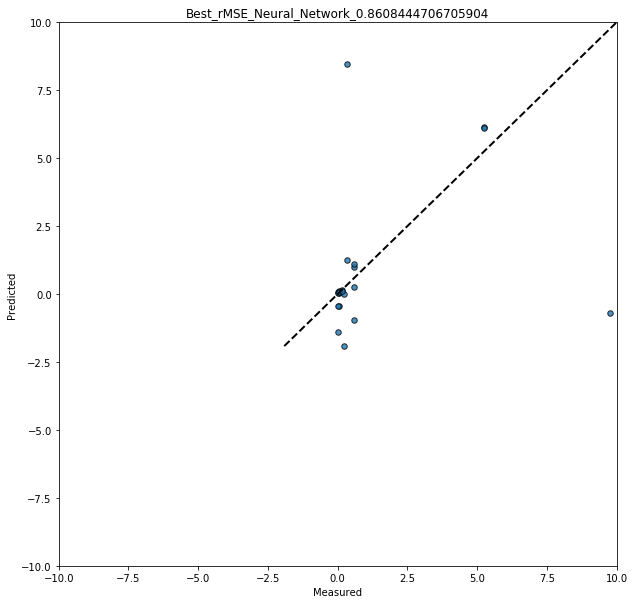

In [0]:
indexSmallest = np.argmin(rMse)
bestPredY = y_preds.reshape(22,6)[:,indexSmallest]
y_actualForBestPred  = y_actual.reshape(22,6)[:,indexSmallest]

saveToFile = True
fileName = "Best_rMSE_Neural_Network_"+str(rMse[indexSmallest])
plotExpectedVsPredictedOutput(y_actualForBestPred,bestPredY,fileName,saveToFile)
print("Best MSE: ",rMse[indexSmallest] )

# Finding best parameters for NN - RSquared

In [0]:
metricToOptimize = LineaReggressionMetrics.R_SQUARED
y_preds = np.array([])
rSquaredArray = np.array([])
y_actual = np.array([])

#### Using Identity activation function, with Adam Solver

In [0]:
pred,rSquare,yTest = runNeuralNetOptimizations(X_cross,y_cross,maxIterations,maxHiddenLayerSize,Activations.identity.name,Solvers.adam.name,hiddenLayerStepSize)
y_preds = np.append(pred,y_preds)
rSquaredArray = np.append(rSquare,rSquaredArray)
y_actual = np.append(yTest,y_actual)

Iteration,minR2coefficientstr,bestRandomStateInitialization,hidden_layer_size,activation,solver 

Best values for NN 

3,0.748165161538346,0,1,identity,adam

Best values for NN, using holdout data 

3,-0.16248093976204858,0,1,identity,adam



#### Using Identity activation function, with Gradient Descent Solver

In [0]:
pred,rSquared,yTest = runNeuralNetOptimizations(X_cross,y_cross,maxIterations,maxHiddenLayerSize,Activations.identity.name,Solvers.sgd.name,hiddenLayerStepSize)
y_preds = np.append(pred,y_preds)
rSquaredArray = np.append(rSquared,rSquaredArray)
y_actual = np.append(yTest,y_actual)

Iteration,minR2coefficientstr,bestRandomStateInitialization,hidden_layer_size,activation,solver 

Best values for NN 

2,0.852861464299513,0,541,identity,sgd

Best values for NN, using holdout data 

2,0.4725763369300776,0,541,identity,sgd



#### Using tanh activation function, with Adam Solver

In [0]:
pred,rSquared,yTest = runNeuralNetOptimizations(X_cross,y_cross,maxIterations,maxHiddenLayerSize,Activations.tanh.name,Solvers.adam.name,hiddenLayerStepSize)
y_preds = np.append(pred,y_preds)
rSquaredArray = np.append(rSquared,rSquaredArray)
y_actual = np.append(yTest,y_actual)

Iteration,minR2coefficientstr,bestRandomStateInitialization,hidden_layer_size,activation,solver 

Best values for NN 

2,0.6640066054738145,4,221,tanh,adam

Best values for NN, using holdout data 

2,-0.30266170242523915,4,221,tanh,adam



#### Using tanh activation function, with Gradient Descent Solver

In [0]:
pred,rSquared,yTest = runNeuralNetOptimizations(X_cross,y_cross,maxIterations,maxHiddenLayerSize,Activations.tanh.name,Solvers.sgd.name,hiddenLayerStepSize)
y_preds = np.append(pred,y_preds)
rSquaredArray = np.append(rSquared,rSquaredArray)
y_actual = np.append(yTest,y_actual)

Iteration,minR2coefficientstr,bestRandomStateInitialization,hidden_layer_size,activation,solver 

Best values for NN 

0,0.8361014723481413,4,41,tanh,sgd

Best values for NN, using holdout data 

0,0.26521002310834063,4,41,tanh,sgd



#### Using relu activation function, with Adam Solver

In [0]:
pred,rSquared,yTest = runNeuralNetOptimizations(X_cross,y_cross,maxIterations,maxHiddenLayerSize,Activations.relu.name,Solvers.adam.name,hiddenLayerStepSize)
y_preds = np.append(pred,y_preds)
rSquaredArray = np.append(rSquared,rSquaredArray)
y_actual = np.append(yTest,y_actual)

Iteration,minR2coefficientstr,bestRandomStateInitialization,hidden_layer_size,activation,solver 

Best values for NN 

4,0.9936143272088319,4,101,relu,adam

Best values for NN, using holdout data 

4,0.8826624153503375,4,101,relu,adam



#### Using relu activation function, with Gradient Descent Solver

In [0]:
pred,rSquared,yTest = runNeuralNetOptimizations(X_cross,y_cross,maxIterations,maxHiddenLayerSize,Activations.relu.name,Solvers.sgd.name,hiddenLayerStepSize)
y_preds = np.append(pred,y_preds)
rSquaredArray = np.append(rSquared,rSquaredArray)
y_actual = np.append(yTest,y_actual)

Iteration,minR2coefficientstr,bestRandomStateInitialization,hidden_layer_size,activation,solver 

Best values for NN 

1,0.9940028525178936,4,21,relu,sgd

Best values for NN, using holdout data 

1,0.8530238597637125,4,21,relu,sgd



Best R Squared:  0.8826624153503375


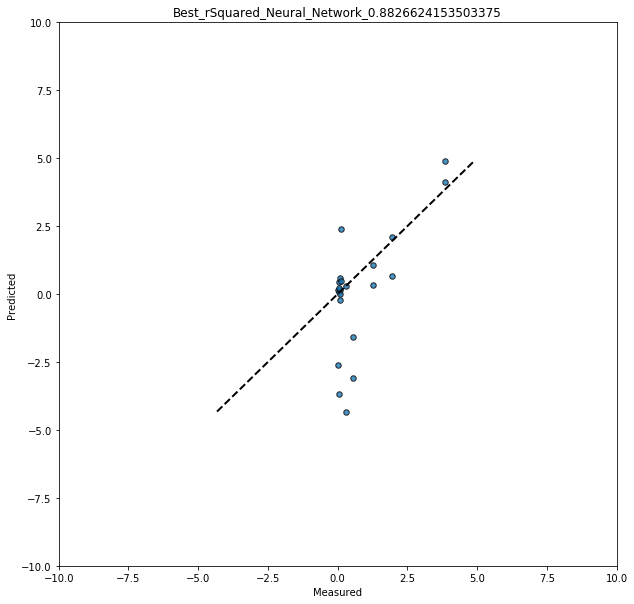

In [0]:
indexSmallest = np.argmax(rSquaredArray)
bestPredY = y_preds.reshape(22,6)[:,indexSmallest]
y_actualForBestPred  = y_actual.reshape(22,6)[:,indexSmallest]

saveToFile = True
fileName = "Best_rSquared_Neural_Network_"+str(rSquaredArray[indexSmallest])
plotExpectedVsPredictedOutput(y_actualForBestPred,bestPredY,fileName,saveToFile)
print("Best R Squared: ",rSquaredArray[indexSmallest] )